In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import random
import string
import tensorflow as tf
from tensorflow.python.ops.rnn_cell import _linear
import zipfile
from six.moves import range
from six.moves.urllib.request import urlretrieve
import collections
import matplotlib.pyplot as plt
import codecs
import time
import os
import gc
from six.moves import cPickle as pickle

from plot_module import text_plot
from plot_module import structure_vocabulary_plots
from plot_module import ComparePlots

from model_module import maybe_download
from model_module import read_data
from model_module import check_not_one_byte
from model_module import id2char
from model_module import char2id
from model_module import BatchGenerator
from model_module import characters
from model_module import batches2string
from model_module import logprob
from model_module import sample_distribution
from model_module import MODEL

In [2]:
if not os.path.exists('enwik8_filtered'):
    if not os.path.exists('enwik8'):
        filename = maybe_download('enwik8.zip', 36445475)
    full_text = read_data(filename)
    new_text = u""
    new_text_list = list()
    for i in range(len(full_text)):
        if (i+1) % 10000000 == 0:
            print("%s characters are filtered" % i)
        if ord(full_text[i]) < 256:
            new_text_list.append(full_text[i])
    text = new_text.join(new_text_list)
    del new_text_list
    del new_text
    del full_text

    (not_one_byte_counter, min_character_order_index, max_character_order_index, number_of_characters, present_characters_indices) = check_not_one_byte(text)

    print("number of not one byte characters: ", not_one_byte_counter) 
    print("min order index: ", min_character_order_index)
    print("max order index: ", max_character_order_index)
    print("total number of characters: ", number_of_characters)
    
    f = open('enwik8_filtered', 'w')
    f.write(text.encode('utf8'))
    f.close()
    
else:
    f = open('enwik8_filtered', 'r')
    text = f.read().decode('utf8')
    f.close() 
    (not_one_byte_counter, min_character_order_index, max_character_order_index, number_of_characters, present_characters_indices) = check_not_one_byte(text)

    print("number of not one byte characters: ", not_one_byte_counter) 
    print("min order index: ", min_character_order_index)
    print("max order index: ", max_character_order_index)
    print("total number of characters: ", number_of_characters)    

number of not one byte characters:  0
min order index:  9
max order index:  255
total number of characters:  196


In [3]:
#different
offset = 20000
valid_size = 10000
valid_text = text[offset:offset+valid_size]
train_text = text[offset+valid_size:]
train_size = len(train_text)
print(train_size, train_text[:64])
print(valid_size, valid_text[:64])

99350000 n in the February 1934 riots, anarchists divided over a 'united 
10000 ture in Mutual Aid: A Factor of Evolution (1897). Subsequent ana


In [4]:
vocabulary_size = number_of_characters
vocabulary = list()
characters_positions_in_vocabulary = list()

character_position_in_vocabulary = 0
for i in range(256):
    if present_characters_indices[i]:
        vocabulary.append(unichr(i))
        characters_positions_in_vocabulary.append(character_position_in_vocabulary)
        character_position_in_vocabulary += 1
    else:
        characters_positions_in_vocabulary.append(-1)


string_vocabulary = u""
for i in range(vocabulary_size):
    string_vocabulary += vocabulary[i]
print("Vocabulary: ", string_vocabulary)
print("char2id(u'a') = %s,  char2id(u'z') = %s,  char2id(u' ') = %s" % (char2id(u'a', characters_positions_in_vocabulary),
                                                                        char2id(u'z', characters_positions_in_vocabulary),
                                                                        char2id(u' ', characters_positions_in_vocabulary)))
print("id2char(78) = %s,  id2char(156) = %s,  id2char(140) = %s" % (id2char(78,
                                                                            vocabulary),
                                                                    id2char(156,
                                                                            vocabulary),
                                                                    id2char(140,
                                                                            vocabulary)))

Vocabulary:  	
 !"#$%&'()*+,-./0123456789:;<=>?@ABCDEFGHIJKLMNOPQRSTUVWXYZ[\]^_`abcdefghijklmnopqrstuvwxyz{|}~ ¡¢£¤¥¦§¨©ª«¬­®¯°±²³´µ¶·¸¹º»¼½¾¿ÀÁÂÃÄÅÆÇÈÉÊËÌÍÎÏÐÑÒÓÔÕÖ×ØÙÚÛÜÝÞßàáâãäåæçèéêëìíîïðñòóôõö÷øùúûüýþÿ
char2id(u'a') = 67,  char2id(u'z') = 92,  char2id(u' ') = 2
id2char(78) = l,  id2char(156) = Ø,  id2char(140) = È


In [5]:
batch_size_test=64
num_unrollings_test=10

train_batches_test = BatchGenerator(train_text,
                                    batch_size_test,
                                    vocabulary_size,
                                    characters_positions_in_vocabulary,
                                    num_unrollings_test)
valid_batches_test = BatchGenerator(valid_text,
                                    1,
                                    vocabulary_size,
                                    characters_positions_in_vocabulary,
                                    1)

print(batches2string(train_batches_test.next(), vocabulary))
print(batches2string(train_batches_test.next(), vocabulary))
print(batches2string(valid_batches_test.next(), vocabulary))
print(batches2string(valid_batches_test.next(), vocabulary))

[u'n in the Fe', u".\n* ''[[Con", u"oldier's so", u'\xf6hm-Bawerk ', u'tification,', u' warrior, a', u'uot; would ', u' 115       ', u'orbata acid', u'>\n      <co', u'ate, the co', u'other natio', u'ing the his', u'et bromine;', u' Christ&quo', u' average]] ', u' their home', u'ks and a ri', u'on]]/[[Joel', u' new era fo', u'aph that th', u' known as t', u's from the ', u'ast majorit', u'trips, thou', u'ent of regi', u'metric aspe', u'd named by ', u'Z</timestam', u'tude of 1 c', u'!&quot; [ht', u'o ==\n\n* [[D', u'[[Belarusia', u'iton]], Rus', u'ccessful si', u'es his theo', u' explain th', u' the South.', u'sing with a', u'd ball is h', u'e could des', u'[Friedrich ', u'th virtuall', u' foreign ac', u'variant in ', u'd and watch', u"t; ''[[Foot", u' became Lea', u'stern Europ', u' </contribu', u'ese terms n', u'arting in t', u'gence of th', u'of the cons', u'uickly swit', u', thus star', u'lly develop', u'g the offic', u'esult, the ', u'red HMMWV. ', u'ament is de', u'University ', 

In [6]:



class adaptive_random(MODEL):
    def layer(self, 
              inp_t,
              state_t_minus_1,
              memory_t_minus_1):
        X_t = tf.concat(1, [inp_t,
                            state_t_minus_1,
                            memory_t_minus_1])
        RES = tf.matmul(X_t, self.Matrix) + self.Bias
        state_t = tf.tanh(RES)
        return state_t

    
    def iteration(self, inp, state):
        output = self.layer(inp,
                            state[0],
                            state[1])
        trigger = tf.sigmoid(tf.matmul(tf.concat(1, [inp, output]), self.trigger_matrix) + self.trigger_bias)
        trigger = tf.reshape(trigger, [-1])
        memory_list = list()
        current_batch_size = trigger.get_shape().as_list()[0]
        swap = tf.greater(trigger, self.thresh)
        output_coef = tf.to_float(swap)
        memory_coef = tf.constant(1., shape=[current_batch_size])
        memory_coef = memory_coef - output_coef
        memory = tf.transpose(output_coef * trigger * tf.transpose(output) + memory_coef * tf.transpose(state[1])) 
        return output, [output, memory], trigger
    
    def swap_iteration(self, inp, state):
        output = self.layer(inp,
                            state[0],
                            state[1])
        trigger = tf.sigmoid(tf.matmul(tf.concat(1, [inp, output]), self.trigger_matrix) + self.trigger_bias)
        trigger = tf.reshape(trigger, [-1])
        swap_prob = tf.constant(self._swap_prob) 
        swap = tf.less(tf.random_uniform([1])[0], swap_prob)
        coef_output = tf.to_float(swap)
        coef_memory = tf.constant(1.) - coef_output
        memory = coef_output * tf.transpose(trigger * tf.transpose(output)) + coef_memory * state[1]  
        return output, [output, memory], trigger
    
    def unrollings(self, train_inputs, saved_state):
        outputs = list()
        state = saved_state
        triggers = list()
        for inp in train_inputs:
            output, state, current_trigger = self.iteration(inp, state)
            outputs.append(output)  
            triggers.append(current_trigger)
        return [tf.concat(0, outputs), tf.concat(0, state), tf.concat(0, triggers)]
    
    def swap_unrollings(self, train_inputs, saved_state):
        outputs = list()
        state = saved_state
        triggers = list()
        for inp in train_inputs:
            output, state, current_trigger = self.swap_iteration(inp, state)
            outputs.append(output) 
            triggers.append(current_trigger)
        return [tf.concat(0, outputs), tf.concat(0, state), tf.concat(0, triggers)]

    
    def __init__(self,
                 batch_size,
                 vocabulary,
                 characters_positions_in_vocabulary,
                 num_unrollings,
                 num_layers,
                 num_nodes,
                 init_bias,
                 threshhold,    #{'fixed': True/False, 'min':  , 'max':  ,'epochs':  }
                 normal_run_prob,
                 swap_prob,
                 train_text,
                 valid_text,
                 mean=0.,
                 stddev='default',
                 shift=0.,
                 init_learning_rate=1.):
        self._results = list()
        self._batch_size = batch_size
        self._vocabulary = vocabulary
        self._vocabulary_size = len(vocabulary)
        self._characters_positions_in_vocabulary = characters_positions_in_vocabulary
        self._num_unrollings = num_unrollings
        self._num_layers = num_layers
        self._num_nodes = num_nodes
        self._init_bias = init_bias
        self._threshold = threshold
        self._normal_run_prob = normal_run_prob
        self._swap_prob = swap_prob
        self._train_text = train_text
        self._valid_text = valid_text
        self._valid_size = len(valid_text)
        
        
        self._mean = mean
        
        self._stddev = list()
        if stddev == 'default':
            self._stddev = 1.0 * np.sqrt(1.3/(2*num_nodes[0] + vocabulary_size))
        else:
            self._stddev = stddev
            
        self._shift = shift
        self._init_learning_rate = init_learning_rate
        
        self._indices = {"batch_size": 0,
                         "num_unrollings": 1,
                         "num_layers": 2,
                         "num_nodes": 3,
                         "half_life": 4,
                         "decay": 5,
                         "num_steps": 6,
                         "averaging_number": 7,
                         "init_bias": 8,
                         "threshold": 9,
                         "normal_run_prob": 10,
                         "swap_prob": 11,
                         "memory_fine":12,
                         "init_mean": 13,
                         "init_stddev": 14,
                         "init_shift": 15,
                         "init_learning_rate": 16,
                         "type": 17}
        self._graph = tf.Graph()
        
        self._last_num_steps = 0
        with self._graph.as_default(): 
            with self._graph.device('/gpu:0'): 
                self.Matrix = tf.Variable(tf.truncated_normal([self._vocabulary_size + 2*self._num_nodes[0],
                                                               self._num_nodes[0]],
                                                              mean=self._mean, stddev=self._stddev))
                self.Bias = tf.Variable([self._shift for _ in range(self._num_nodes[0])])

                # classifier 
                weights = tf.Variable(tf.truncated_normal([self._num_nodes[-1], self._vocabulary_size], stddev = 0.1))
                bias = tf.Variable(tf.zeros([self._vocabulary_size]))
                
                self.trigger_matrix = tf.Variable(tf.truncated_normal([self._vocabulary_size + self._num_nodes[0], 1], stddev = 0.1))
                self.trigger_bias = tf.Variable([self._init_bias])
                
                """PLACEHOLDERS train data"""
                self._train_data = list()
                for _ in range(self._num_unrollings + 1):
                    self._train_data.append(
                        tf.placeholder(tf.float32, shape=[self._batch_size, self._vocabulary_size]))
                train_inputs = self._train_data[: self._num_unrollings]
                train_labels = self._train_data[1:]  # labels are inputs shifted by one time step.
                # Unrolled LSTM loop.

                saved_state = [tf.Variable(tf.zeros([self._batch_size, self._num_nodes[0]]), trainable=False),
                               tf.Variable(tf.zeros([self._batch_size, self._num_nodes[0]]), trainable=False)]
                
                """global step"""
                self._global_step = tf.Variable(0)
                
                normal_prob = tf.minimum(
                    tf.constant(self._normal_run_prob['init']) + tf.to_float(self._global_step) / self._normal_run_prob['epochs'] * tf.constant(1. - self._normal_run_prob['init']),
                    tf.constant(1.))
                """swap"""
                swap = tf.greater(tf.random_uniform([1])[0], normal_prob) 
                """self.thresh"""
                if self._threshold['fixed']:
                    self.thresh = tf.constant(self._threshold['min'])
                else:
                    thresh_range = self._threshold['max'] - self._threshold['min']
                    self.thresh = tf.minimum(tf.constant(self._threshold['min']) + tf.to_float(self._global_step) / self._threshold['epochs'] * tf.constant(thresh_range), tf.constant(self._threshold['max']))
                outputs = list()
                state = saved_state
                [outputs, state, current_trigger] = tf.cond(swap,
                                                            lambda: self.swap_unrollings(train_inputs, state),
                                                            lambda: self.unrollings(train_inputs, state))

                state = tf.split(0, 2, state)
                save_list = list()
                
                save_list.append(saved_state[0].assign(state[0]))
                save_list.append(saved_state[1].assign(state[1]))
                
                """skip operation"""
                self._skip_operation = tf.group(*save_list)
                
                self.memory_fine = tf.placeholder(tf.float32)
                mf = tf.minimum(tf.to_float(swap), self.memory_fine)
                with tf.control_dependencies(save_list):
                        # Classifier.
                    logits = tf.nn.xw_plus_b(outputs, weights, bias)
                    """loss"""
                    self._loss = tf.reduce_mean(
                        tf.nn.softmax_cross_entropy_with_logits(
                        logits, tf.concat(0, train_labels)))
                    fact_loss = tf.reduce_mean(
                                                tf.nn.softmax_cross_entropy_with_logits(
                                                logits, tf.concat(0, train_labels))) + mf * tf.reduce_sum(current_trigger)

                # Optimizer.
                
                """PLACEHOLDERS half life and decay"""
                self._half_life = tf.placeholder(tf.int32)
                self._decay = tf.placeholder(tf.float32)
                """learning rate"""
                self._learning_rate = tf.train.exponential_decay(self._init_learning_rate,
                                                                 self._global_step,
                                                                 self._half_life,
                                                                 self._decay,
                                                                 staircase=True)
                optimizer = tf.train.GradientDescentOptimizer(self._learning_rate)
                gradients, v = zip(*optimizer.compute_gradients(fact_loss))
                gradients, _ = tf.clip_by_global_norm(gradients, 1.25)
                """optimizer"""
                self._optimizer = optimizer.apply_gradients(zip(gradients, v), global_step=self._global_step)
                """train prediction"""
                self._train_prediction = tf.nn.softmax(logits)

                # Sampling and validation eval: batch 1, no unrolling.
                saved_sample_state = list()
                saved_sample_state.append(tf.Variable(tf.zeros([1, self._num_nodes[0]]), trainable=False)) 
                saved_sample_state.append(tf.Variable(tf.zeros([1, self._num_nodes[0]]), trainable=False)) 
                """PLACEHOLDER sample input"""
                self._sample_input = tf.placeholder(tf.float32, shape=[1, self._vocabulary_size])

                reset_list = list()
                reset_list.append(saved_sample_state[0].assign(tf.zeros([1, self._num_nodes[0]])))
                reset_list.append(saved_sample_state[1].assign(tf.zeros([1, self._num_nodes[0]])))

                """reset sample state"""
                self._reset_sample_state = tf.group(*reset_list)
                
                """trigger"""
                sample_output, sample_state, self.trigger = self.iteration(self._sample_input, saved_sample_state)
                
                self.trigger = tf.reshape(self.trigger, [1, 1])

                sample_save_list = list()
                sample_save_list.append(saved_sample_state[0].assign(sample_state[0]))
                sample_save_list.append(saved_sample_state[1].assign(sample_state[1]))

                with tf.control_dependencies(sample_save_list):
                    """sample prediction"""
                    self._sample_prediction = tf.nn.softmax(tf.nn.xw_plus_b(sample_output, weights, bias)) 
                
                
                """saver"""
                self.saver = tf.train.Saver(max_to_keep=None)
                            
                        
    
    def _generate_metadata(self, half_life, decay, num_averaging_iterations, memory_fine):
        metadata = list()
        metadata.append(self._batch_size)
        metadata.append(self._num_unrollings)
        metadata.append(self._num_layers)
        metadata.append(self._num_nodes)
        metadata.append(half_life)
        metadata.append(decay)
        metadata.append(self._last_num_steps)
        metadata.append(num_averaging_iterations)
        metadata.append(self._init_bias)
        metadata.append(dict(self._threshold))
        metadata.append(self._normal_run_prob)
        metadata.append(self._swap_prob)
        metadata.append(memory_fine)
        metadata.append(self._mean)
        metadata.append(self._stddev)
        metadata.append(self._shift)
        metadata.append(self._init_learning_rate)
        metadata.append('adaptive_random')
        return metadata
  
    def get_triggers(self, session, num_strings=10, length=75, start_positions=None):
        self._reset_sample_state.run()
        self._valid_batches = BatchGenerator(self._valid_text,
                                             1,
                                             self._vocabulary_size,
                                             self._characters_positions_in_vocabulary,
                                             1)
        if start_positions is None:
            start_positions = list()
            if self._valid_size / num_strings < length:
                num_strings = self._valid_size / length
            for i in range(num_strings):
                start_positions.append(i* (self._valid_size / num_strings) + self._valid_size / num_strings / 2)
            while self._valid_size - start_positions[-1] < length:
                del start_positions[-1]
        text_list = list()
        trigger_list = list()
        collect_triggers = False
        letters_parsed = -1
        for idx in range(self._valid_size):
            b = self._valid_batches.next()
            
            if idx in start_positions or collect_triggers: 
                if letters_parsed == -1:
                    letters_parsed = 0
                    text = u""
                    t_list = list()
                    collect_triggers = True
                text += characters(b[0], self._vocabulary)[0]
                t_list.append(self.trigger.eval({self._sample_input: b[0]}))
                letters_parsed += 1
                if letters_parsed >= length:
                    collect_triggers = False
                    trigger_list.append(t_list)
                    text_list.append(text)
                    letters_parsed = -1
                    
            _ = self._sample_prediction.eval({self._sample_input: b[0]})
        return text_list, trigger_list 

In [7]:
threshold = {'fixed': True, 'min': 0.5, 'max': 0.7, 'epochs': 10000}
normal_run_prob = {'init': 0.1, 'epochs': 10000}

model = adaptive_random(64,
                 vocabulary,
                 characters_positions_in_vocabulary,
                 30,
                 1,
                 [128],
                 0.,
                 threshold,    #{'fixed': True/False, 'min':  , 'max':  ,'epochs':  }
                 normal_run_prob,
                        0.1,
                 train_text,
                 valid_text)

In [15]:
optional_feed_dict = {'self.memory_fine': 0.0000001}
model.run(30,
          0.9,
            200,
            50,
            3,
            1,
            20,
          optional_feed_dict=optional_feed_dict,
            print_intermediate_results = True)

KeyboardInterrupt: 

In [23]:
normal_run_prob = {'init': 0.1, 'epochs': 79000}

threshold_values = [0.5]
reduce_coef = 2.
num_iter = 8
memory_fine_value = 0.0000001
threshold = {'fixed': True, 'min': 0.2, 'max': 0.7, 'epochs': 10000}
optional_feed_dict = {'self.memory_fine': 0.001}
results_GL = list()
for threshold_value in threshold_values:
    print("\n", ' '*5, "threshold: ", threshold_value)
    threshold['min'] = threshold_value
    for _ in range(num_iter):
        print("memory fine: ", memory_fine_value)
        optional_feed_dict['self.memory_fine'] = memory_fine_value
        model = adaptive_random(64,
                         vocabulary,
                         characters_positions_in_vocabulary,
                         30,
                         1,
                         [128],
                         0.,
                         threshold,    #{'fixed': True/False, 'min':  , 'max':  ,'epochs':  }
                                normal_run_prob,
                                0.1,
                         train_text,
                         valid_text)
        model.simple_run(100,
                       'adaptive_random/new/variables/swpr0.1_th%s_mf%s' % (threshold_value, memory_fine_value),
                       80000,
                       4000,
                       5000,        #learning has a chance to be stopped after every block of steps
                       30,
                       0.9,
                       3,
                       optional_feed_dict=optional_feed_dict)
        results_GL.extend(model._results)
        model.destroy()
        del model
        gc.collect()
        memory_fine_value /= reduce_coef


       threshold:  0.5
memory fine:  1e-07
Number of steps = 80001     Percentage = 50.59%     Time = 4607s     Learning rate = 0.0424
memory fine:  5e-08
Number of steps = 80001     Percentage = 50.66%     Time = 4655s     Learning rate = 0.0424
memory fine:  2.5e-08
Number of steps = 80001     Percentage = 50.45%     Time = 4654s     Learning rate = 0.0424
memory fine:  1.25e-08
Number of steps = 80001     Percentage = 50.37%     Time = 4717s     Learning rate = 0.0424
memory fine:  6.25e-09
Number of steps = 80001     Percentage = 50.65%     Time = 4764s     Learning rate = 0.0424
memory fine:  3.125e-09
Number of steps = 80001     Percentage = 50.47%     Time = 4643s     Learning rate = 0.0424
memory fine:  1.5625e-09
Number of steps = 80001     Percentage = 50.43%     Time = 4655s     Learning rate = 0.0424
memory fine:  7.8125e-10
Number of steps = 80001     Percentage = 50.38%     Time = 4734s     Learning rate = 0.0424


In [24]:
folder_name = 'adaptive_random'
file_name = 'adaptive_random_ns_80000_hl_2667_dc_0.9_ib0_ilr1._th0.5_mf1e-7_7.8e-10_ni7.pickle'
force = True
pickle_dump = {'results_GL': results_GL}
if not os.path.exists(folder_name):
    try:
        os.makedirs(folder_name)
    except Exception as e:
        print("Unable create folder '%s'" % folder_name, ':', e)    
print('Pickling %s.' % (folder_name + '/' + file_name))
try:
    with open(folder_name + '/' + file_name, 'wb') as f:
        pickle.dump(pickle_dump, f, pickle.HIGHEST_PROTOCOL)
except Exception as e:
    print('Unable to save data to', file_name, ':', e)

Pickling adaptive_random/adaptive_random_ns_80000_hl_2667_dc_0.9_ib0_ilr1._th0.5_mf1e-7_7.8e-10_ni7.pickle.


In [ ]:
folder_name = 'adaptive_random'
pickle_file = 'adaptive_random_ns_80000_hl_2667_dc_0.9_ib0_ilr1._th0.5_mf1e-6_1.6e-8_ni7.pickle'

with open(folder_name + '/' + pickle_file, 'rb') as f:
  save = pickle.load(f)
  results_GL = save['results_GL']
  del save  # hint to help gc free up memory

In [8]:
folder_name = 'adaptive_random'
pickle_file = 'adaptive_random_ns_80000_hl_2667_dc_0.9_ib0_ilr1._th0.5_mf1e-7_7.8e-10_ni7.pickle'

with open(folder_name + '/' + pickle_file, 'rb') as f:
  save = pickle.load(f)
  results_GL = save['results_GL']
  del save  # hint to help gc free up memory

In [9]:
from plot_module import ComparePlots

adaptive_random_plots = ComparePlots('adaptive_random')
adaptive_random_plots.add_network(results_GL, model._indices)



/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family [u'normal'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


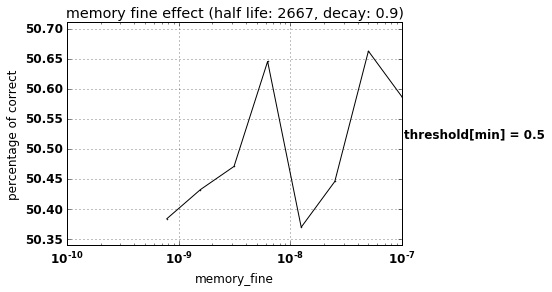

In [10]:
plot_options = {'x': 'log'}
plot_data, _ = adaptive_random_plots.one_key_layout_data('adaptive_random_1',
                                         'memory_fine',
                                         "threshold['min']")
adaptive_random_plots.save_layout(plot_data[0],
                    'memory fine effect (half life: 2667, decay: 0.9)',
                    ['memory_fine_effect', 'plots'],
                    'new_nn128;ns80000;hl2667;dc0.9',
                              plot_options=plot_options)
adaptive_random_plots.draw(plot_data[0], 'memory fine effect (half life: 2667, decay: 0.9)', plot_options=plot_options)

In [11]:
normal_run_prob = {'init': 0.1, 'epochs': 79000}
threshold_values = [0.5]
memory_fine_values = [(0.0000001 / 2**i) for i in range(8)]
threshold = {'fixed': True, 'min': 0.2, 'max': 0.7, 'epochs': 10000}
optional_feed_dict = {'self.memory_fine': 0.001}
results_GL = list()
for threshold_value in threshold_values:
    print("\n", ' '*5, "threshold: ", threshold_value)
    threshold['min'] = threshold_value
    for memory_fine_value in memory_fine_values:
        print("memory fine: ", memory_fine_value)
        model = adaptive_random(64,
                         vocabulary,
                         characters_positions_in_vocabulary,
                         30,
                         1,
                         [128],
                         0.,
                         threshold,    #{'fixed': True/False, 'min':  , 'max':  ,'epochs':  }
                                normal_run_prob,
                                0.07,
                         train_text,
                         valid_text)
        text_list, trigger_list = model.run_for_analitics(model.get_triggers,
                                                        'adaptive_random/new/variables/swpr0.1_th%s_mf%s' % (threshold_value, memory_fine_value),
                                                        [100, 75, None])
        triggers = list()
        for text_number, text in enumerate(text_list):
            trig = list()

            text_triggers = trigger_list[text_number]
            for text_trigger in text_triggers:
                trig.append(text_trigger[0, 0])
            triggers.append(trig)
        structure_vocabulary_plots(text_list,
                                   triggers,
                                   'triggers for letter position (threshold %s, memory fine %s)' % (threshold_value, memory_fine_value),
                                   'mean trigger',
                                   ['adaptive_random', 'triggers', 'vocabulary_plots'],
                                   'swpr0.1_ib0_th%s_mf%s' % (threshold_value, memory_fine_value),
                                   show=False)
        for i in range(99):
            text_plot(text_list[i],
                      triggers[i],
                      'trigger',
                      'triggers (threshold %s, memory fine %s)' % (threshold_value, memory_fine_value),
                      ['adaptive_random', 'text_plots', 'new7', 'th%s_mf%s' % (threshold_value, memory_fine_value)],
                      'swpr0.1_ib0_th%s_mf%s#%s' % (threshold_value, memory_fine_value, i),
                      show=False)
        model.destroy()
        del model
        gc.collect()


       threshold:  0.5
memory fine:  1e-07
memory fine:  5e-08
memory fine:  2.5e-08
memory fine:  1.25e-08
memory fine:  6.25e-09
memory fine:  3.125e-09
memory fine:  1.5625e-09
memory fine:  7.8125e-10
